In [1]:
import sys
import os
import h5py
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from typing import Union, Tuple, Optional
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.models.dqfno import DQFNO
from src.losses.data_losses import LpLoss, H1Loss
from src.training.adamw import AdamW

In [2]:
data_path = "/Users/anthonypoole/Data/TACC/hw2d_sim_step0.025_end1_pts512_c11_k015_N3_nu5e-8_20250205112740_25678_3.h5"
with h5py.File(data_path, 'r') as f:
    print(f['density'].shape)
    print(f.keys())

(8001, 64, 64)
<KeysViewHDF5 ['density', 'energy', 'enstrophy', 'enstrophy_phi', 'gamma_c', 'gamma_n', 'gamma_n_spectral', 'kinetic_energy', 'omega', 'phi', 'state_density', 'state_omega', 'state_phi', 'thermal_energy', 'time']>


In [3]:
def load_h5_pair(input_file: str, target_file: str, device: torch.device,
                 derived: bool = False) -> Union[Tuple[torch.Tensor, torch.Tensor],
                                                 Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]:
    """
    Loads input and target data from HDF5 files.

    :param input_file: Path to the input file.
    :param target_file: Path to the target file.
    :param device: Torch device.
    :param derived: Whether to load the derived gamma_n quantity.
    :return: Tuple of (x, y) if not derived; otherwise (x, y, gamma_n).
    """
    def load_data(file: str) -> torch.Tensor:
        with h5py.File(file, 'r') as f:
            density = f['density'][:]
            omega = f['omega'][:]
            phi = f['phi'][:]
            # Stack along channel dimension and add a batch dimension.
            data = torch.tensor(np.stack((density, omega, phi), axis=1), dtype=torch.float32)
            # Rearranging dimensions as needed: (B, var_dim, T, H, W)
            return data.unsqueeze(0).permute(0, 2, 1, 3, 4)

    x = load_data(input_file)
    y = load_data(target_file)
    gamma_n: Optional[torch.Tensor] = None

    if derived:
        with h5py.File(target_file, 'r') as f:
            gamma_n = torch.tensor(f['gamma_n'][:], dtype=torch.float32)

    if derived:
        assert gamma_n is not None  # For type-checkers.
        return x.to(device), y.to(device), gamma_n.to(device)
    else:
        return x.to(device), y.to(device)
# Gather HDF5 file pairs.
input_pattern = "../src/data/input*.h5"
target_pattern = "../src/data/target*.h5"
input_files = sorted(glob.glob(input_pattern))
target_files = sorted(glob.glob(target_pattern))
paired_files = list(zip(input_files, target_files))
random.shuffle(paired_files)
split_idx = int(.8 * len(paired_files))
train_files = paired_files[:split_idx]
test_files = paired_files[split_idx:]
for (input_file, target_file) in train_files:
    data = load_h5_pair(input_file, target_file, 'cpu')

In [7]:
modes = [(64,64), (128,128), (32,32)]
model = DQFNO(
    modes=modes,
    in_channels=1,
    out_channels=1,
    hidden_channels=64,
)
model.cpu()
lpLoss= LpLoss(d=4,p=2, reduction='mean')
h1Loss = H1Loss(d=2)
# optim = AdamW(model.parameters(), lr = .00001)
optim = torch.optim.Adam(model.parameters(), lr=.0001)

In [8]:
# Training loop with global normalization
losses = []
model.train()
for j in range(1):
    for i, (input_file, target_file) in enumerate(train_files):
        optim.zero_grad()
        data = load_h5_pair(input_file, target_file, 'cpu')
        x, y = data
        
        # Reshape x and y to: Batch, Channels, Time, V, X, Y
        x = x.reshape(1, 1, 10, 3, 64, 64)
        y = y.reshape(1, 1, 10, 3, 64, 64)
        
        # Forward pass through the model.
        x = model(x)
        
        # Compute the loss (MSE loss in this example)
        loss = torch.nn.functional.mse_loss(x, y)
        loss.backward()
        optim.step()
        
        if i % 10 == 0:
            print(f"Lploss: {float(loss)}")
            losses.append(float(loss))

Lploss: 5.277502536773682
Lploss: 5.541171073913574
Lploss: 5.300093173980713
Lploss: 5.3433613777160645
Lploss: 5.456361293792725
Lploss: 5.447546005249023
Lploss: 4.550539016723633
Lploss: 4.417117595672607
Lploss: 4.194716453552246
Lploss: 2.9878602027893066
Lploss: 2.2163217067718506
Lploss: 2.164247751235962
Lploss: 1.8034136295318604
Lploss: 1.7634098529815674
Lploss: 1.5078731775283813
Lploss: 1.3695335388183594
Lploss: 1.2258431911468506
Lploss: 0.9741716384887695
Lploss: 1.016257882118225
Lploss: 0.8339266180992126
Lploss: 0.8851518630981445
Lploss: 0.7653692364692688
Lploss: 0.7860627770423889
Lploss: 0.7781643271446228
Lploss: 0.7451030015945435
Lploss: 0.7590176463127136
Lploss: 0.7497419118881226
Lploss: 0.6172996759414673
Lploss: 0.7087022662162781
Lploss: 0.6957007646560669
Lploss: 0.6515357494354248
Lploss: 0.6687402725219727
Lploss: 0.7109625339508057
Lploss: 0.7209711670875549
Lploss: 0.6681569814682007
Lploss: 0.6416345834732056
Lploss: 0.6521433591842651
Lploss: 0.6

In [ ]:
print(losses)

[5.331848621368408, 5.385087966918945, 5.27256965637207, 5.237451076507568, 5.563894748687744, 4.893701553344727, 4.86226749420166, 5.54176664352417, 5.381195068359375, 4.934869766235352, 5.602152347564697, 5.584813594818115, 5.382188320159912, 5.278957843780518, 5.092196941375732, 5.420356750488281, 5.36138391494751, 5.5590081214904785, 5.432923316955566, 5.155570030212402, 5.052912712097168, 5.084105968475342, 5.665281772613525, 5.3423919677734375, 4.932694435119629, 5.105858325958252, 5.083306789398193, 5.350167274475098, 5.5876240730285645, 4.997445583343506, 5.3131842613220215, 5.518359661102295, 5.199600696563721, 5.376841068267822, 4.704422950744629, 5.121806621551514, 5.0563812255859375, 5.3348774909973145, 4.794681072235107, 4.92048454284668, 4.4862961769104, 4.647583484649658, 4.772005081176758, 4.518845081329346, 4.665016174316406, 4.617001056671143, 4.383094310760498, 4.356054306030273, 4.3032355308532715, 4.310652256011963, 4.118630886077881, 3.9491193294525146, 3.95451807

tensor(-9.4747) tensor(7.6337) tensor(-0.0756)
tensor(-9.1834) tensor(7.0381) tensor(-0.0871)
tensor(-9.4202) tensor(7.5457) tensor(-0.0813)
tensor(-10.1465) tensor(7.8549) tensor(-0.0804)
tensor(-10.2150) tensor(8.0015) tensor(-0.0797)
tensor(-10.3041) tensor(8.4591) tensor(-0.0915)
tensor(-10.6110) tensor(8.7264) tensor(-0.0918)
tensor(-9.6768) tensor(8.3167) tensor(-0.0877)
tensor(-10.7357) tensor(8.2059) tensor(-0.0873)
tensor(-9.1970) tensor(8.1247) tensor(-0.0766)


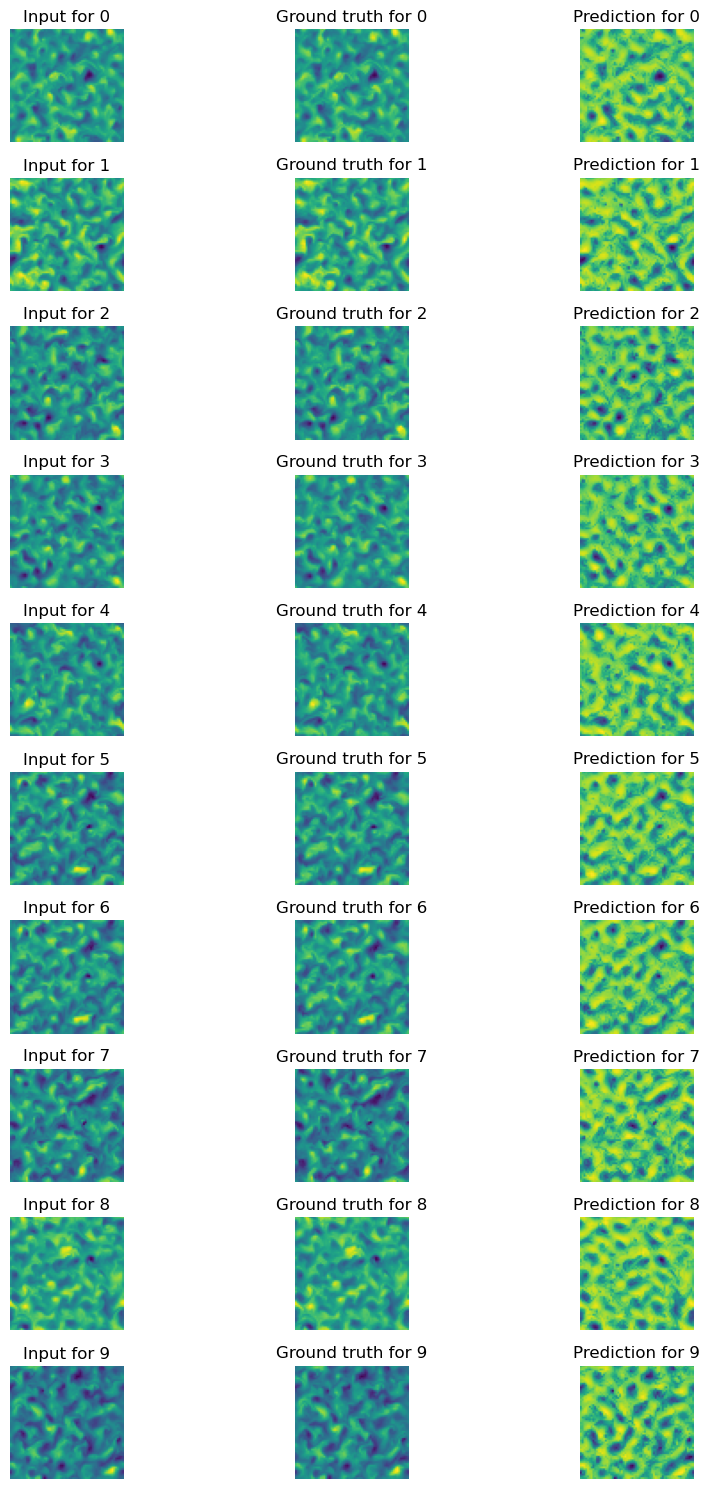

In [ ]:
# Test the trained model
with torch.no_grad():
    plots = 10
    fig, ax = plt.subplots(plots,3, figsize=(10,15))

    for i, (input_file, target_file) in enumerate(test_files):
        if i >=plots:
            break
        data = load_h5_pair(input_file, target_file, 'cpu')
        x, y = data
        x = x.reshape(1, 1, 10, 3, 64,64) # B, C, T, V, X, Y
        y = y.reshape(1, 1, 10, 3, 64,64) # B, C, T, V, X, Y
        pred = model(x)
        print(pred.min(), pred.max(), pred.mean())
        
        x_image = x[0,0,0,0]
        y_image = y[0,0,0,0]
        pred_image = pred[0,0,0,0]
        ax[i,0].imshow(x_image)
        ax[i,0].set_title(f"Input for {i}")
        ax[i,0].axis('off')
        ax[i,1].imshow(y_image)
        ax[i,1].set_title(f"Ground truth for {i}")
        ax[i,1].axis('off')
        ax[i,2].imshow(pred_image)
        ax[i,2].set_title(f"Prediction for {i}")
        ax[i,2].axis('off')

    plt.tight_layout()
    plt.show()